# Introduction

Notebook to analyze the **True Positive** Results for each model in the context of traceability between features and bug reports.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

from modules.models_runner.feat_br_models_runner import Feat_BR_Models_Runner
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import aux_functions
from modules.utils import model_evaluator as m_eval
from modules.utils import similarity_measures as sm
from modules.utils import tokenizers as tok

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Volunteers Only Strategy

In [2]:
models_runner_4 = Feat_BR_Models_Runner()
lsi_model_4 = models_runner_4.run_lsi_model()
lda_model_4 = models_runner_4.run_lda_model()
bm25_model_4 = models_runner_4.run_bm25_model()
w2v_model_4 = models_runner_4.run_word2vec_model()

oracle = fd.Feat_BR_Oracles.read_feat_br_volunteers_df().T

evaluator_4 = m_eval.ModelEvaluator(oracle)
evals_df_4 = evaluator_4.run_evaluator(models=[lsi_model_4,lda_model_4,bm25_model_4,w2v_model_4],
                                       top_values=[1,3,5], 
                                       sim_thresholds=[(sm.SimilarityMeasure.COSINE, x/10) for x in range(0,10)])

Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Feat_BR Volunteers Matrix shape: (91, 19)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Load Datasets

In [3]:
bugreports = fd.Datasets.read_selected_bugreports_df()
features = fd.Datasets.read_features_df()

SelectedBugReports.shape: (91, 18)
Features.shape: (19, 8)


### Tokenization

In [4]:
tokenizer = tok.PorterStemmerBased_Tokenizer()
bugreports['tokens'] = bugreports.apply(lambda row : tokenizer.__call__(row['br_desc']), axis=1)
features['tokens'] = features.apply(lambda row : tokenizer.__call__(row['feat_desc']), axis=1)

### Results

In [5]:
evals_df_4.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_1_cosine_0.1,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.1,1.0,Bug_Number 1248267 1248268 125...
2,lsi,top_1_cosine_0.2,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.2,1.0,Bug_Number 1248267 1248268 125...
3,lsi,top_1_cosine_0.3,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.3,1.0,Bug_Number 1248267 1248268 125...
4,lsi,top_1_cosine_0.4,28.57,26.18,26.62,precision recall fscore Bug_Nu...,0.4,1.0,Bug_Number 1248267 1248268 125...


### Grouping Results by Model

#### Min Precision

model
bm25          11.87
lda            1.10
lsi           12.53
wordvector     7.14
Name: perc_precision, dtype: float64



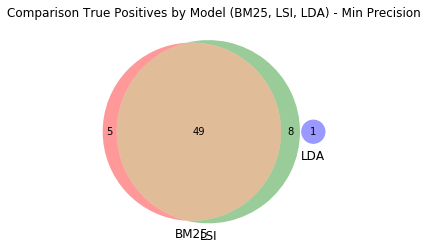

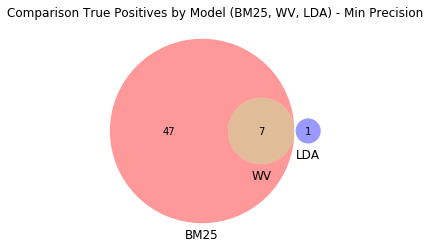

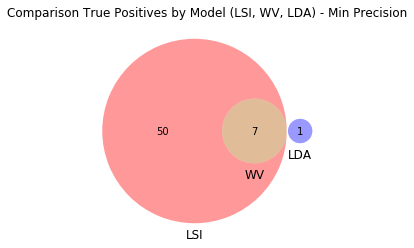

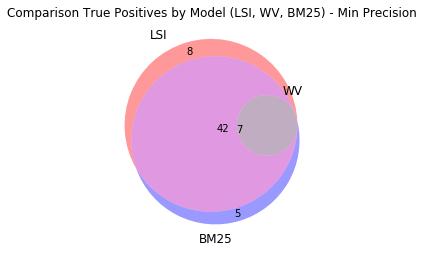

In [6]:
group = evals_df_4.groupby('model').perc_precision.min()
print(group)
print()

bm25_min_prec = group[group.index == 'bm25'].values[0]
lsi_min_prec = group[group.index == 'lsi'].values[0]
lda_min_prec = group[group.index == 'lda'].values[0]
wv_min_prec = group[group.index == 'wordvector'].values[0]

bm25_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_min_prec))
lsi_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_min_prec))
lda_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_min_prec))
wv_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_min_prec))

venn3([bm25_tp_set, lsi_tp_set, lda_tp_set], ['BM25','LSI','LDA'])
plt.title('Comparison True Positives by Model (BM25, LSI, LDA) - Min Precision')
plt.show()

venn3([bm25_tp_set, wv_tp_set, lda_tp_set], ['BM25','WV','LDA'])
plt.title('Comparison True Positives by Model (BM25, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_tp_set, wv_tp_set, lda_tp_set], ['LSI','WV','LDA'])
plt.title('Comparison True Positives by Model (LSI, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_tp_set, wv_tp_set, bm25_tp_set], ['LSI','WV','BM25'])
plt.title('Comparison True Positives by Model (LSI, WV, BM25) - Min Precision')
plt.show()

##### Exclusive Cases

In [7]:
print("BM25 Exclusive TP:")
bm25_exc_set = bm25_tp_set - lsi_tp_set - lda_tp_set - wv_tp_set
display(bm25_exc_set)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set)))

print("\n\nLSI Exclusive TP:")
lsi_exc_set = lsi_tp_set - bm25_tp_set - lda_tp_set - wv_tp_set
display(lsi_exc_set)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set)))

print("\n\nLDA Exclusive TP:")
lda_exc_set = lda_tp_set - lsi_tp_set - bm25_tp_set - wv_tp_set
display(lda_exc_set)
print("len(lda_exc_set): {}".format(len(lda_exc_set)))

print("\n\nWV Exclusive TP:")
wv_exc_set = wv_tp_set - lda_tp_set - lsi_tp_set - bm25_tp_set
display(wv_exc_set)
print("len(wv_exc_set): {}".format(len(wv_exc_set)))

BM25 Exclusive TP:


{('apz_async_scrolling', 1287687),
 ('downloads_dropmaker', 1432915),
 ('flac_support', 1295502),
 ('new_awesome_bar', 1451475),
 ('pointer_lock_api', 1314643)}

len(bm25_exc_set): 5


LSI Exclusive TP:


{('browser_customization', 1301784),
 ('browser_customization', 1344446),
 ('pdf_viewer', 1301056),
 ('pdf_viewer', 1365887),
 ('tts_in_rm', 1335538),
 ('w10_comp', 1279140),
 ('webgl_comp', 1295502),
 ('zoom_indicator', 1305195)}

len(lsi_exc_set): 8


LDA Exclusive TP:


{('webgl_comp', 1312018)}

len(lda_exc_set): 1


WV Exclusive TP:


set()

len(wv_exc_set): 0


##### Word Clouds

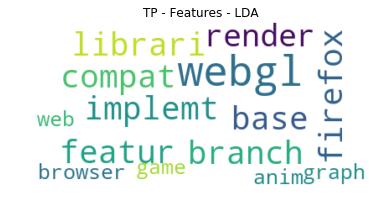

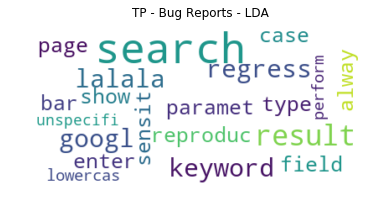

In [8]:
aux_functions.create_wordcloud_feat_br(lda_exc_set, bugreports=bugreports, features=features,
                                     wc_feat_title="TP - Features - LDA",
                                     wc_br_title="TP - Bug Reports - LDA")

In [9]:
aux_functions.detail_features_br(lda_exc_set, features=features, bugreports=bugreports)

,feat,feat_desc,br,br_summary
0,webgl_comp,"Feature of Firefox implemted based on WebGL library for the rendering of games, animations and graphs in the web browser.",1312018,Keyword search is always performed in lowercase


In [10]:
aux_functions.highlight_df(lda_model_4.get_sim_matrix())

In [11]:
lda_model_4.print_topics()

Topic #0: webgl firefox window compat page web open bar tab taskbar drop drag bookmark address match imag base librari featur anim
Topic #1: loud speech read html extens text desktop content page use firefox http branch stop element default set paus code info
Topic #2: element stop default http branch set code info forward field privat paus appear button play avail allow use display email
Topic #3: capabl librari render browser firefox http branch element stop default set appear privat forward paus code info field button play
Topic #4: custom firefox default browser http branch element stop set appear paus info code forward privat field button play avail allow
Topic #5: element stop default http branch set code info forward field privat paus appear button play avail allow use display email
Topic #6: element stop default http branch set code info forward field privat paus appear button play avail allow use display email
Topic #7: menu context option displayport portion apz new zoom pan 

##### True Positives Amount by Model

In [12]:
print("LSI TP Amount: {}".format(len(lsi_tp_set)))
print("LDA TP Amount: {}".format(len(lda_tp_set)))
print("BM25 TP Amount: {}".format(len(bm25_tp_set)))
print("WV TP Amount: {}".format(len(wv_tp_set)))

LSI TP Amount: 57
LDA TP Amount: 1
BM25 TP Amount: 54
WV TP Amount: 7


#### Max Precision

In [ ]:
group = evals_df_4.groupby('model').perc_precision.max()
print(group)
print()

bm25_max_prec = group[group.index == 'bm25'].values[0]
lsi_max_prec = group[group.index == 'lsi'].values[0]
lda_max_prec = group[group.index == 'lda'].values[0]
wv_max_prec = group[group.index == 'wordvector'].values[0]

bm25_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_max_prec))
lsi_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_max_prec))
lda_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_max_prec))
wv_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_max_prec))

venn3([bm25_tp_set, lsi_tp_set, lda_tp_set], ['BM25','LSI','LDA'])
plt.title('Comparison True Positives by Model (BM25, LSI, LDA) - Max Precision')
plt.show()

venn3([bm25_tp_set, wv_tp_set, lda_tp_set], ['BM25','WV','LDA'])
plt.title('Comparison True Positives by Model (BM25, WV, LDA) - Max Precision')
plt.show()

venn3([lsi_tp_set, wv_tp_set, lda_tp_set], ['LSI','WV','LDA'])
plt.title('Comparison True Positives by Model (LSI,WV,LDA) - Max Precision')
plt.show()

venn3([lsi_tp_set, wv_tp_set, bm25_tp_set], ['LSI','WV','BM25'])
plt.title('Comparison True Positives by Model (LSI, WV, BM25) - Max Precision')
plt.show()

##### Exclusive Cases

In [ ]:
print("BM25 Exclusive TP:")
bm25_exc_set = bm25_tp_set - lsi_tp_set - lda_tp_set - wv_tp_set
display(bm25_exc_set)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set)))

print("\n\nLSI Exclusive TP:")
lsi_exc_set = lsi_tp_set - bm25_tp_set - lda_tp_set - wv_tp_set
display(lsi_exc_set)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set)))

print("\n\nLDA Exclusive TP:")
lda_exc_set = lda_tp_set - lsi_tp_set - bm25_tp_set - wv_tp_set
display(lda_exc_set)
print("len(lda_exc_set): {}".format(len(lda_exc_set)))

print("\n\nWV Exclusive TP:")
wv_exc_set = wv_tp_set - lda_tp_set - lsi_tp_set - bm25_tp_set
display(wv_exc_set)
print("len(wv_exc_set): {}".format(len(wv_exc_set)))

##### Word Clouds

In [ ]:
aux_functions.create_wordcloud_feat_br(lda_exc_set, bugreports=bugreports, features=features,
                                     wc_feat_title="TP - Features - LDA",
                                     wc_br_title="TP - Bug Reports - LDA")

##### True Positives Amount by Model

In [ ]:
print("LSI TP Amount: {}".format(len(lsi_tp_set)))
print("LDA TP Amount: {}".format(len(lda_tp_set)))
print("BM25 TP Amount: {}".format(len(bm25_tp_set)))
print("WV TP Amount: {}".format(len(wv_tp_set)))

#### Min Recall

In [ ]:
group = evals_df_4.groupby('model').perc_recall.min()
print(group)
print()

bm25_min_recall = group[group.index == 'bm25'].values[0]
lsi_min_recall = group[group.index == 'lsi'].values[0]
lda_min_recall = group[group.index == 'lda'].values[0]
wv_min_recall = group[group.index == 'wordvector'].values[0]

bm25_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_min_recall))
lsi_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_min_recall))
lda_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_min_recall))
wv_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_min_recall))

venn3([bm25_tp_set, lsi_tp_set, lda_tp_set], ['BM25','LSI','LDA'])
plt.title('Comparison True Positives by Model (BM25, LSI, LDA) - Min Recall')
plt.show()

venn3([bm25_tp_set, wv_tp_set, lda_tp_set], ['BM25','WV','LDA'])
plt.title('Comparison True Positives by Model (BM25, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_tp_set, wv_tp_set, lda_tp_set], ['LSI','WV','LDA'])
plt.title('Comparison True Positives by Model (LSI, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_tp_set, wv_tp_set, bm25_tp_set], ['LSI','WV','BM25'])
plt.title('Comparison True Positives by Model (LSI, WV, BM25) - Min Precision')
plt.show()

##### Exclusive Cases

In [ ]:
print("BM25 Exclusive TP:")
bm25_exc_set = bm25_tp_set - lsi_tp_set - lda_tp_set - wv_tp_set
display(bm25_exc_set)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set)))

print("\n\nLSI Exclusive TP:")
lsi_exc_set = lsi_tp_set - bm25_tp_set - lda_tp_set - wv_tp_set
display(lsi_exc_set)
print("len(bm25_exc_set): {}".format(len(lsi_exc_set)))

print("\n\nLDA Exclusive TP:")
lda_exc_set = lda_tp_set - lsi_tp_set - bm25_tp_set - wv_tp_set
display(lda_exc_set)
print("len(lda_exc_set): {}".format(len(lda_exc_set)))

print("\n\nWV Exclusive TP:")
wv_exc_set = wv_tp_set - lda_tp_set - lsi_tp_set - bm25_tp_set
display(wv_exc_set)
print("len(wv_exc_set: {})".format(len(wv_exc_set)))

##### True Positives Amount by Model

In [ ]:
print("LSI TP Amount: {}".format(len(lsi_tp_set)))
print("LDA TP Amount: {}".format(len(lda_tp_set)))
print("BM25 TP Amount: {}".format(len(bm25_tp_set)))
print("WV TP Amount: {}".format(len(wv_tp_set)))

#### Max Recall

In [ ]:
group = evals_df_4.groupby('model').perc_recall.max()
print(group)
print()

bm25_max_recall = group[group.index == 'bm25'].values[0]
lsi_max_recall = group[group.index == 'lsi'].values[0]
lda_max_recall = group[group.index == 'lda'].values[0]
wv_max_recall = group[group.index == 'wordvector'].values[0]

bm25_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_max_recall))
lsi_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_max_recall))
lda_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_max_recall))
wv_tp_set = aux_functions.get_true_positives( oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_max_recall))

venn3([bm25_tp_set, lsi_tp_set, lda_tp_set], ['BM25','LSI','LDA'])
plt.title('Comparison True Positives by Model (BM25, LSI, LDA) - Max Recall')
plt.show()

venn3([bm25_tp_set, wv_tp_set, lda_tp_set], ['BM25','WV','LDA'])
plt.title('Comparison True Positives by Model (Bm25, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_tp_set, wv_tp_set, lda_tp_set], ['LSI','WV','LDA'])
plt.title('Comparison True Positives by Model (LSI, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_tp_set, wv_tp_set, bm25_tp_set], ['LSI','WV','BM25'])
plt.title('Comparison True Positives by Model (LSI, WV, BM25) - Max Recall')
plt.show()

##### Exclusive Cases

In [ ]:
print("BM25 Exclusive TP:")
bm25_exc_set = bm25_tp_set - lsi_tp_set - lda_tp_set - wv_tp_set
display(bm25_exc_set)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set)))

print("\n\nLSI Exclusive TP:")
lsi_exc_set = lsi_tp_set - bm25_tp_set - lda_tp_set - wv_tp_set
display(lsi_exc_set)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set)))

print("\n\nLDA Exclusive TP:")
lda_exc_set = lda_tp_set - lsi_tp_set - bm25_tp_set - wv_tp_set
display(lda_exc_set)
print("len(lda_exc_set): {}".format(len(lda_exc_set)))

print("\n\nWV Exclusive TP:")
wv_exc_set = wv_tp_set - lda_tp_set - lsi_tp_set - bm25_tp_set
display(wv_exc_set)
print("len(wv_exc_set): {}".format(len(wv_exc_set)))

##### True Positives Amount by Model

In [ ]:
print("LSI TP Amount: {}".format(len(lsi_tp_set)))
print("LDA TP Amount: {}".format(len(lda_tp_set)))
print("BM25 TP Amount: {}".format(len(bm25_tp_set)))
print("WV TP Amount: {}".format(len(wv_tp_set)))